### Predicting hand written integers using scikit learn

In [44]:
### the dataset can be downloaded from sklearn 
#from sklearn.datasets import fetch_openml
#mnist = fetch_openml('mnist_784', version=1)

# I downloaded the dataset on my local dir
import pandas as pd

mnist_csv = open("mnist-in-csv/mnist_train.csv", "r")
mnist_df = pd.read_csv(mnist_csv)

mnist_test = open("mnist-in-csv/mnist_test.csv", "r")
mnist_test_df = pd.read_csv(mnist_test)

mnist_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
X = mnist_df.drop("label", axis=1)
y = mnist_df['label']

X_tst = mnist_test_df.drop("label", axis=1)
y_tst = mnist_test_df['label']

X.shape
y.shape

(60000,)

### Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s imshow() function.

In [64]:
print(X.loc[0])
print(y[0])

1x1      0
1x2      0
1x3      0
1x4      0
1x5      0
        ..
28x24    0
28x25    0
28x26    0
28x27    0
28x28    0
Name: 0, Length: 784, dtype: int64
5


### Visualizing an Integer
Selecting an integer in the DataFrame and converting it in to NumPy array to apply reshape() on it.

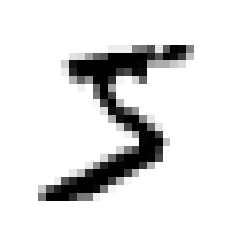

In [68]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

some_digit = X.loc[0].to_numpy()
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [69]:
X_train, X_test, y_train, y_test = X, X_tst, y, y_tst

### A Binary Classifier
will treat the instances of 5 as positive and all other digits as negative class.

In [70]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

### Applying Stochastic Gradient Descent 
SGD classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because it deals with training instances independently, one at a time (which also makes SGD well suited for online learning).

In [71]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [72]:
# does it work?
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures for a Classifier
There are different methods to measure the performance of a classifier. 

1. cross_validation

### Manual Cross Validation using a Function

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

### cross_val_score

In [73]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [76]:
# applying a base estimator will give similar accuracy as the data is skewed

from sklearn.base import BaseEstimator
import numpy as np
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).

## Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. We can use the cross_val_predict() function.

In [77]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [78]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

NameError: name 'y_train_5' is not defined

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

NameError: name 'y_train_5' is not defined

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()

NameError: name 'fpr' is not defined